In [1]:
import copy
import glob
import pickle
import warnings
from datetime import datetime, timedelta
from itertools import product
import joblib
import os

import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(42)
import pandas as pd
import shapely.geometry as sgeom
import xarray as xr
from scipy import stats
from scipy.spatial.distance import cdist
from shapely import geometry
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import cluster_analysis, narm_analysis, som_analysis

In [2]:
import verify

In [3]:
import optuna
from optuna.samplers import TPESampler
from optuna.integration import TFKerasPruningCallback

/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-16 23:55:27.964629: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_slice

In [5]:
variables = ['z500']
name_var = ['z500']
units = ['m2/s2']

In [6]:
import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, AveragePooling2D, Dropout
from keras.utils import to_categorical
from keras.layers import LeakyReLU
from keras.layers import ReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [7]:
df_wr_2 = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/weekly_wr_mean_geop_v3.csv',
                     index_col=0,parse_dates=True)

df_wr_2 = df_wr_2.dropna()
df_wr_2_train = df_wr_2.iloc[np.where(df_wr_2.index.year<=2010)[0]]
#only test period
df_wr_2 = df_wr_2.iloc[np.where(df_wr_2.index.year>2010)[0]]

In [8]:
path_figures = '/glade/u/home/jhayron/WeatherRegimes/Figures/Evaluation_Z500_w012_v2/'
variable = variables[0]

dic_results = np.load('/glade/work/jhayron/Weather_Regimes/models_results/CNN_v7/dic_results.npy',
                     allow_pickle=True)[()]
dic_probability = np.load('/glade/work/jhayron/Weather_Regimes/models_results/CNN_v7/dic_probability.npy',
                     allow_pickle=True)[()]

df_results_persistence = pd.read_csv('/glade/work/jhayron/Weather_Regimes/models_results/CNN_v7/dic_probability_persistence.csv',
                                    index_col=0,parse_dates=True)

# 1. Plot Optuna results

/glade/scratch/jhayron/ipykernel_25783/1692106266.py:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


368


/glade/scratch/jhayron/ipykernel_25783/1692106266.py:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


922


/glade/scratch/jhayron/ipykernel_25783/1692106266.py:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


893


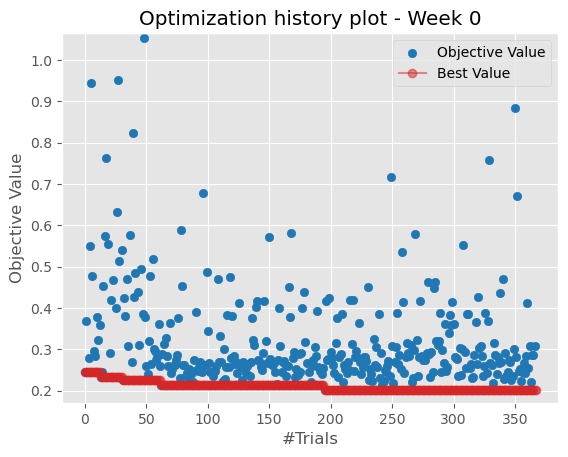

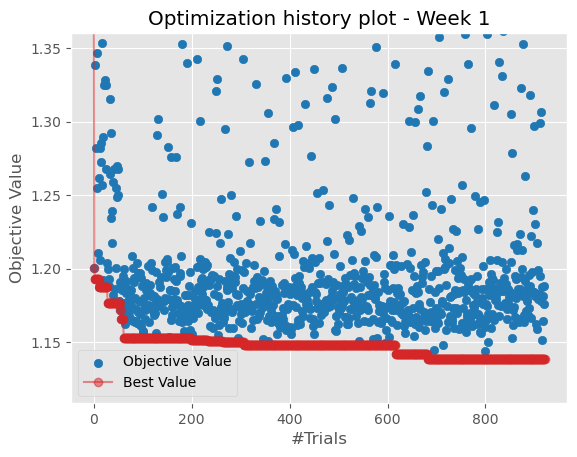

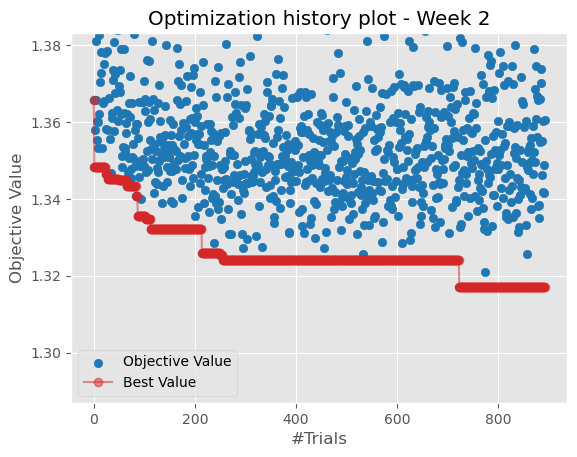

In [9]:
for i,week in enumerate(['week1','week2','week3']):
    results_directory = f'/glade/work/jhayron/Weather_Regimes/models/CNN/results_optuna/{week}/'
    study = joblib.load(results_directory + 'optuna_study_v2.pkl')
    
    plot_optimization_history(study)
    print(len(study.trials_dataframe().value))
    plt.ylim(np.nanmin(study.trials_dataframe().value)-0.03,np.nanpercentile(study.trials_dataframe().value,96))
    plt.title(f'Optimization history plot - Week {i}')
    plt.savefig(f'{path_figures}OptunaHistory_week{i}.png',bbox_inches='tight')

/glade/scratch/jhayron/ipykernel_25783/2405471643.py:5: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)
/glade/scratch/jhayron/ipykernel_25783/2405471643.py:5: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)
/glade/scratch/jhayron/ipykernel_25783/2405471643.py:5: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


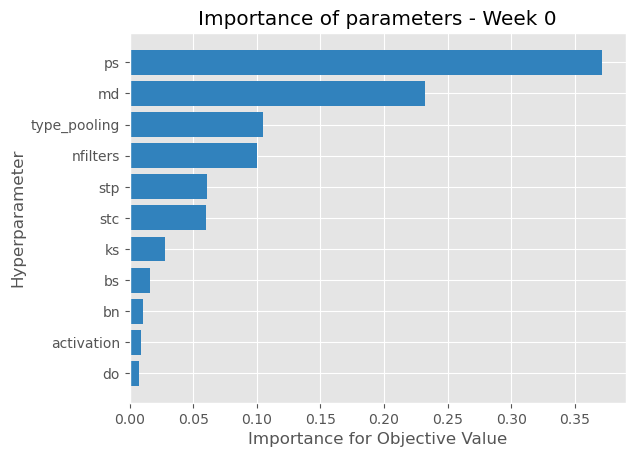

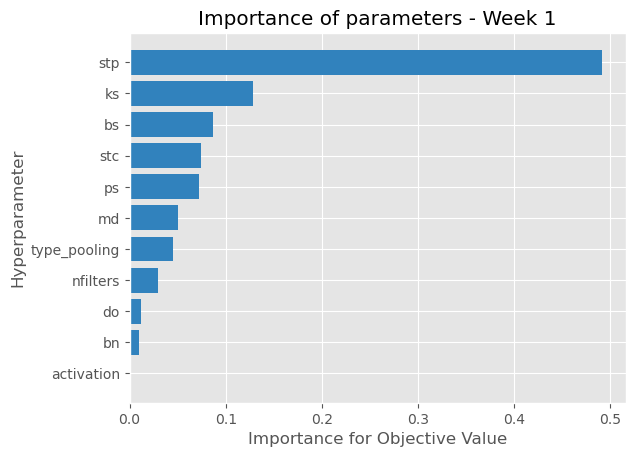

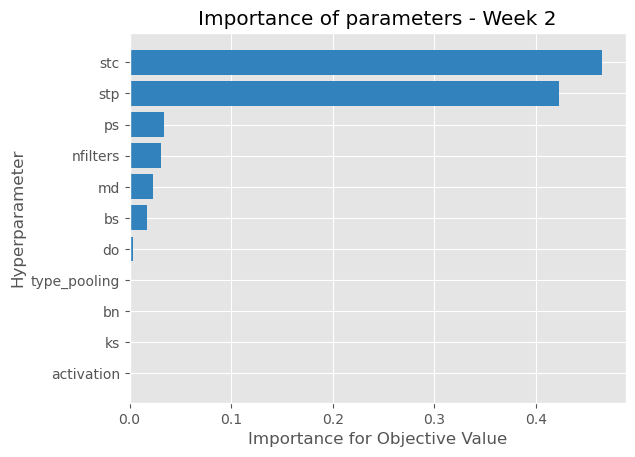

In [10]:
for i,week in enumerate(['week1','week2','week3']):
    results_directory = f'/glade/work/jhayron/Weather_Regimes/models/CNN/results_optuna/{week}/'
    study = joblib.load(results_directory + 'optuna_study_v2.pkl')
    
    plot_param_importances(study)
    plt.title(f'Importance of parameters - Week {i}')
    plt.savefig(f'{path_figures}OptunaParamsImportance_week{i}.png',bbox_inches='tight')

In [12]:
colors= ['darkorange','mediumaquamarine','mediumpurple']

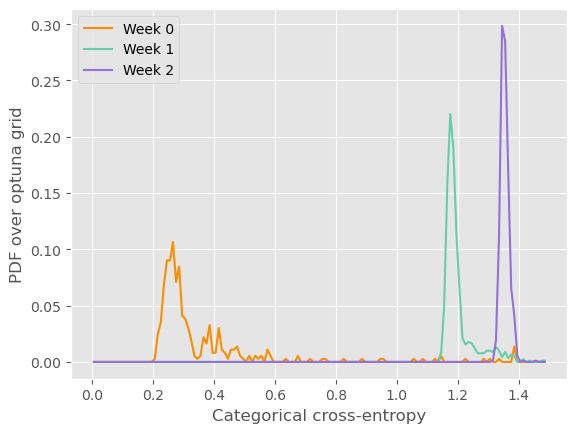

In [13]:
for i,week in enumerate(['week1','week2','week3']):
    results_directory = f'/glade/work/jhayron/Weather_Regimes/models/CNN/results_optuna/{week}/'
    df_results = pd.read_csv(results_directory + 'df_optuna_results_v2.csv',index_col=0)

    hist,bins = np.histogram(df_results.value.dropna(),bins=np.arange(0,1.5,0.01))
    hist = hist/np.sum(hist)
    bins2plot = bins[:-1]+np.diff(bins)[0]/2

    plt.plot(bins2plot,hist,label=f'{week[:-1].capitalize()} {i}',color=colors[i])
plt.legend()
plt.xlabel('Categorical cross-entropy')
plt.ylabel('PDF over optuna grid')
plt.savefig(f'{path_figures}OptunaCrossEntropy.png',bbox_inches='tight')

# 2. Evaluate accuracy and probability distributions

In [14]:
acc_weeks_model = []
acc_weeks_persistence = []

for week in ['week1','week2','week3']:
    acc_weeks_persistence.append(accuracy_score(df_results_persistence[week],df_wr_2[week]))
    acc_weeks_model.append(accuracy_score(dic_results['z500'][week],df_wr_2[week]))

In [15]:
acc_weeks_simple = copy.deepcopy(acc_weeks_model)

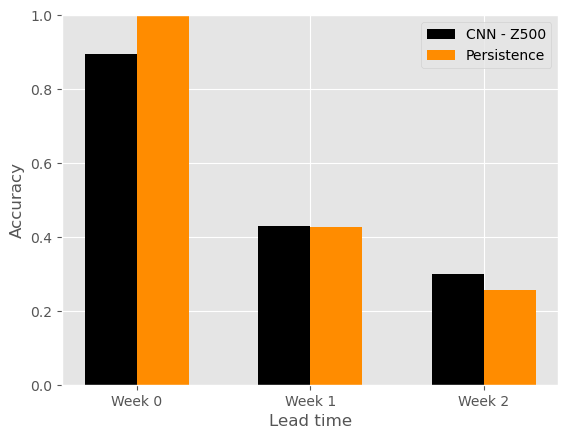

In [16]:
### PLOT BARS ###
plt.bar(np.arange(3),acc_weeks_model,width=-0.3,align='edge',label=f'CNN - {variable.upper()}',color='k')
plt.bar(np.arange(3),acc_weeks_persistence,width=0.3,align='edge',label='Persistence',color='darkorange')
plt.legend()
plt.ylabel('Accuracy')
plt.xticks(np.arange(3),['Week 0','Week 1','Week 2'])
plt.xlabel('Lead time')
plt.ylim(0,1)

plt.savefig(f'{path_figures}Accuracy.png',bbox_inches='tight')
# plt.close('all')

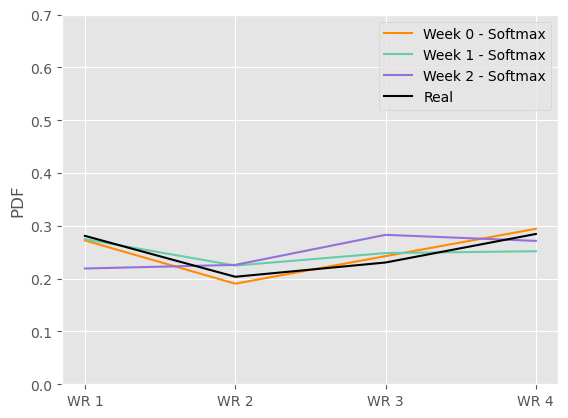

In [17]:
colors= ['darkorange','mediumaquamarine','mediumpurple']

hist_real = np.histogram(df_wr_2['week1'],bins=[-0.5,0.5,1.5,2.5,3.5])[0]
hist_real_norm = hist_real/np.sum(hist_real)

for i,week in enumerate(['week1','week2','week3']):
    plt.plot(dic_probability['z500'][week].mean(axis=0),
             label=f'{week[:-1].capitalize()} {i} - Softmax',color=colors[i])
    
    hist_prediction = np.histogram(dic_results['z500'][week],bins=[-0.5,0.5,1.5,2.5,3.5])[0]
    hist_prediction_norm = hist_prediction/np.sum(hist_prediction)
    
#     plt.plot(hist_prediction_norm,
#              label=f'{week[:-1].capitalize()} {i} - Binary',ls='--',color=colors[i])
    
plt.plot(hist_real_norm,color='k',label='Real')

plt.legend()

plt.ylim(0,0.7)
plt.xticks(np.arange(4),['WR 1','WR 2','WR 3','WR 4'])
plt.ylabel('PDF')
plt.savefig(f'{path_figures}Distributions0.png',bbox_inches='tight')

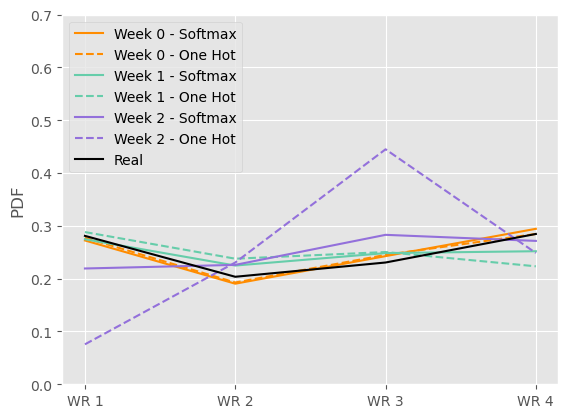

In [18]:
colors= ['darkorange','mediumaquamarine','mediumpurple']

hist_real = np.histogram(df_wr_2['week1'],bins=[-0.5,0.5,1.5,2.5,3.5])[0]
hist_real_norm = hist_real/np.sum(hist_real)

for i,week in enumerate(['week1','week2','week3']):
    plt.plot(dic_probability['z500'][week].mean(axis=0),
             label=f'{week[:-1].capitalize()} {i} - Softmax',color=colors[i])
    
    hist_prediction = np.histogram(dic_results['z500'][week],bins=[-0.5,0.5,1.5,2.5,3.5])[0]
    hist_prediction_norm = hist_prediction/np.sum(hist_prediction)
    
    plt.plot(hist_prediction_norm,
             label=f'{week[:-1].capitalize()} {i} - One Hot',ls='--',color=colors[i])
    
plt.plot(hist_real_norm,color='k',label='Real')

plt.legend()

plt.ylim(0,0.7)
plt.xticks(np.arange(4),['WR 1','WR 2','WR 3','WR 4'])
plt.ylabel('PDF')
plt.savefig(f'{path_figures}Distributions.png',bbox_inches='tight')

# 3. More probability analysis

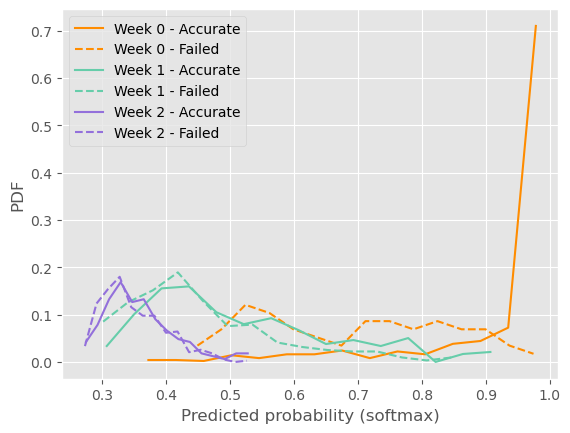

In [19]:
for i,week in enumerate(['week1','week2','week3']):
    where_accurate = np.where(dic_results['z500'][week] == df_wr_2[week])[0]
    where_failed = np.where(dic_results['z500'][week] != df_wr_2[week])[0]
    
    hist,bins = np.histogram(dic_probability['z500'][week].max(axis=1)[where_accurate],bins=15)
    hist = hist/np.sum(hist)
    bins2plot = bins[:-1]+np.diff(bins)[0]/2
    plt.plot(bins2plot,hist,label=f'{week[:-1].capitalize()} {i} - Accurate',color=colors[i])
    
    hist,bins = np.histogram(dic_probability['z500'][week].max(axis=1)[where_failed],bins=15)
    hist = hist/np.sum(hist)
    bins2plot = bins[:-1]+np.diff(bins)[0]/2
    plt.plot(bins2plot,hist,label=f'{week[:-1].capitalize()} {i} - Failed',color=colors[i],ls='--')
    
    
plt.legend()
plt.xlabel('Predicted probability (softmax)')
plt.ylabel('PDF')

plt.savefig(f'{path_figures}FA_PredictedProbabilityDistribution.png',bbox_inches='tight')

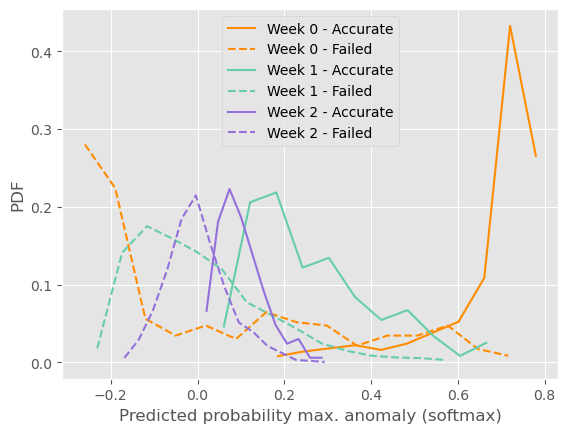

In [20]:
for i,week in enumerate(['week1','week2','week3']):
    where_accurate = np.where(dic_results['z500'][week] == df_wr_2[week])[0]
    where_failed = np.where(dic_results['z500'][week] != df_wr_2[week])[0]
    
    prob_anom = dic_probability['z500'][week] - dic_probability['z500'][week].mean(axis=0)
    hist,bins = np.histogram(prob_anom.max(axis=1)[where_accurate],bins=11)
    hist = hist/np.sum(hist)
    bins2plot = bins[:-1]+np.diff(bins)[0]/2
    plt.plot(bins2plot,hist,label=f'{week[:-1].capitalize()} {i} - Accurate',color=colors[i])
    
    prob_anom = dic_probability['z500'][week] - dic_probability['z500'][week].mean(axis=0)
    hist,bins = np.histogram(prob_anom[where_failed],bins=15)
    hist = hist/np.sum(hist)
    bins2plot = bins[:-1]+np.diff(bins)[0]/2
    plt.plot(bins2plot,hist,label=f'{week[:-1].capitalize()} {i} - Failed',color=colors[i],ls='--')
    
    
plt.legend()
plt.xlabel('Predicted probability max. anomaly (softmax)')
plt.ylabel('PDF')

plt.savefig(f'{path_figures}FA_PredictedProbabilityAnomalyDistribution.png',bbox_inches='tight')

# 4. Handle probability output differently

In [21]:
hist_real_train = np.histogram(df_wr_2_train['week1'],bins=4)[0]
hist_real_train_norm = hist_real_train/np.sum(hist_real_train)

## Decision tree 1

In [22]:
def get_class_from_probabilites_DT1(probabilities,prob_anoms):
    class_temp = np.argmax(probabilities)
    anom_max_prob = prob_anoms[class_temp]
    if anom_max_prob>=0:
        return class_temp
    elif anom_max_prob<0:
        class_temp = np.argmax(prob_anoms)
        return class_temp

In [23]:
dic_results2 = copy.deepcopy(dic_results)

In [24]:
for i,week in enumerate(['week1','week2','week3']):
    prob_anom = dic_probability['z500'][week] - hist_real_train_norm
    results_temp = []
    for j in range(len(dic_probability['z500'][week])):
        class_temp = get_class_from_probabilites_DT1(dic_probability['z500'][week][j],
                                                    prob_anom[j])
        results_temp.append(class_temp)
    dic_results2['z500'][week] = results_temp

In [25]:
acc_weeks_model = []
acc_weeks_persistence = []

for week in ['week1','week2','week3']:
    acc_weeks_persistence.append(accuracy_score(df_results_persistence[week],df_wr_2[week]))
    acc_weeks_model.append(accuracy_score(dic_results2['z500'][week],df_wr_2[week]))

In [26]:
acc_weeks_dt1 = copy.deepcopy(acc_weeks_model)

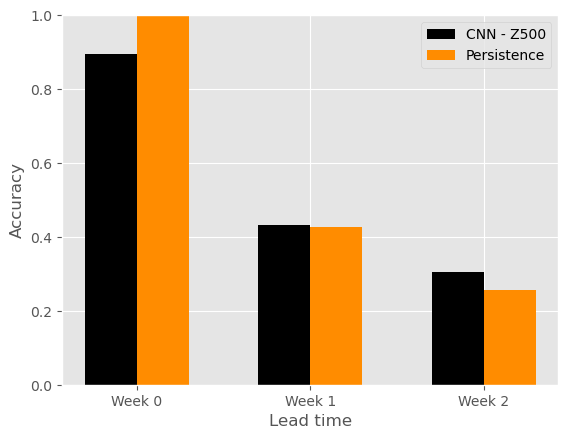

In [27]:
### PLOT BARS ###
plt.bar(np.arange(3),acc_weeks_model,width=-0.3,align='edge',label=f'CNN - {variable.upper()}',color='k')
plt.bar(np.arange(3),acc_weeks_persistence,width=0.3,align='edge',label='Persistence',color='darkorange')
plt.legend()
plt.ylabel('Accuracy')
plt.xticks(np.arange(3),['Week 0','Week 1','Week 2'])
plt.xlabel('Lead time')
plt.ylim(0,1)
plt.savefig(f'{path_figures}Accuracy_DT1.png',bbox_inches='tight')
# plt.close('all')

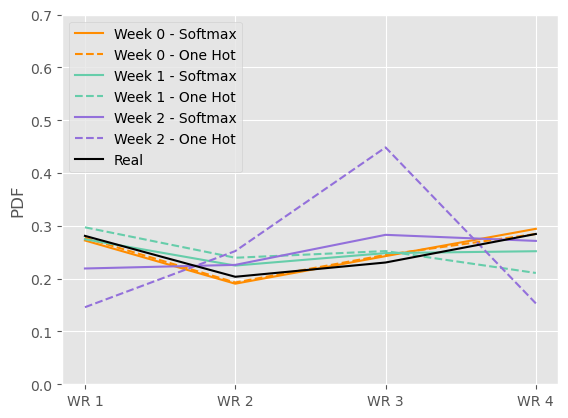

In [28]:
colors= ['darkorange','mediumaquamarine','mediumpurple']

hist_real = np.histogram(df_wr_2['week1'],bins=4)[0]
hist_real_norm = hist_real/np.sum(hist_real)

for i,week in enumerate(['week1','week2','week3']):
    plt.plot(dic_probability['z500'][week].mean(axis=0),
             label=f'{week[:-1].capitalize()} {i} - Softmax',color=colors[i])
    
    hist_prediction = np.histogram(dic_results2['z500'][week],bins=[-0.5,0.5,1.5,2.5,3.5])[0]
    hist_prediction_norm = hist_prediction/np.sum(hist_prediction)

    plt.plot(hist_prediction_norm,
             label=f'{week[:-1].capitalize()} {i} - One Hot',ls='--',color=colors[i])
    
plt.plot(hist_real_norm,color='k',label='Real')

plt.legend()

plt.ylim(0,0.7)
plt.xticks(np.arange(4),['WR 1','WR 2','WR 3','WR 4'])
plt.ylabel('PDF')
plt.savefig(f'{path_figures}Distributions_DT1.png',bbox_inches='tight')

## Decision tree 2

In [29]:
def get_class_from_probabilites_DT2(probabilities,prob_anoms):
    class_temp = np.argmax(probabilities)
    anom_max_prob = prob_anoms[class_temp]
    if anom_max_prob>=0:
        return class_temp
    else:
        return -1

In [30]:
dic_results3 = copy.deepcopy(dic_results)

In [31]:
for i,week in enumerate(['week1','week2','week3']):
    prob_anom = dic_probability['z500'][week] - hist_real_train_norm
    results_temp = []
    for j in range(len(dic_probability['z500'][week])):
        class_temp = get_class_from_probabilites_DT2(dic_probability['z500'][week][j],
                                                    prob_anom[j])
        results_temp.append(class_temp)
    dic_results3['z500'][week] = results_temp

In [32]:
acc_weeks_model = []
acc_weeks_persistence = []

for week in ['week1','week2','week3']:
    where_known = np.where(dic_results3['z500'][week]!=-1)[0]
    acc_weeks_persistence.append(accuracy_score(df_results_persistence[week],
                                                df_wr_2[week]))
    acc_weeks_model.append(accuracy_score(dic_results3['z500'][week].iloc[where_known],
                                          df_wr_2[week].iloc[where_known]))

In [33]:
acc_weeks_dt2 = copy.deepcopy(acc_weeks_model)

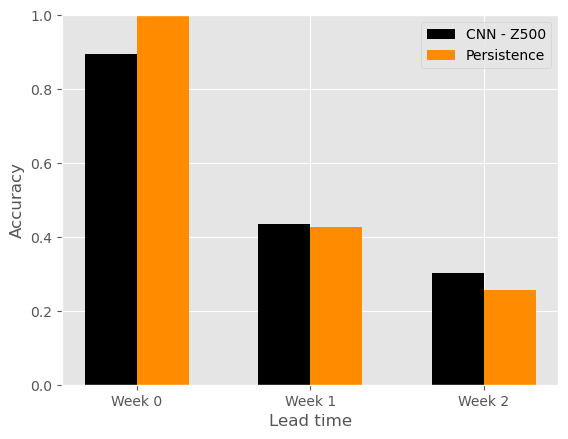

In [34]:
### PLOT BARS ###
plt.bar(np.arange(3),acc_weeks_model,width=-0.3,align='edge',label=f'CNN - {variable.upper()}',color='k')
plt.bar(np.arange(3),acc_weeks_persistence,width=0.3,align='edge',label='Persistence',color='darkorange')
plt.legend()
plt.ylabel('Accuracy')
plt.xticks(np.arange(3),['Week 0','Week 1','Week 2'])
plt.xlabel('Lead time')
plt.ylim(0,1)
plt.savefig(f'{path_figures}Accuracy_DT2.png',bbox_inches='tight')
# plt.close('all')

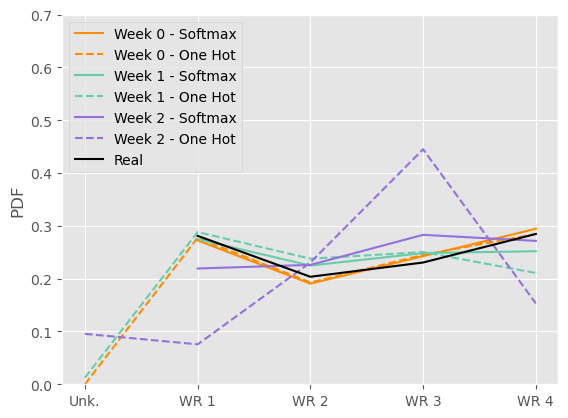

In [35]:
colors= ['darkorange','mediumaquamarine','mediumpurple']

hist_real = np.histogram(df_wr_2['week1'],bins=4)[0]
hist_real_norm = hist_real/np.sum(hist_real)

for i,week in enumerate(['week1','week2','week3']):
    plt.plot(dic_probability['z500'][week].mean(axis=0),
             label=f'{week[:-1].capitalize()} {i} - Softmax',color=colors[i])
    hist_prediction = np.histogram(dic_results3['z500'][week],bins=[-1.5,-0.5,0.5,1.5,2.5,3.5])[0]
    hist_prediction_norm = hist_prediction/np.sum(hist_prediction)

    plt.plot(np.arange(-1,4),hist_prediction_norm,
             label=f'{week[:-1].capitalize()} {i} - One Hot',ls='--',color=colors[i])
    
plt.plot(hist_real_norm,color='k',label='Real')

plt.legend()

plt.ylim(0,0.7)
plt.xticks(np.arange(-1,4),['Unk.','WR 1','WR 2','WR 3','WR 4'])
plt.ylabel('PDF')
plt.savefig(f'{path_figures}Distributions_DT2.png',bbox_inches='tight')

## Predicting with anomaly

In [36]:
def get_class_from_probabilites_DT3(probabilities,prob_anoms):
    class_temp = np.argmax(prob_anoms)
    return class_temp

In [37]:
dic_results4 = copy.deepcopy(dic_results)

In [38]:
for i,week in enumerate(['week1','week2','week3']):
    prob_anom = dic_probability['z500'][week] - hist_real_train_norm
    results_temp = []
    for j in range(len(dic_probability['z500'][week])):
        class_temp = get_class_from_probabilites_DT3(dic_probability['z500'][week][j],
                                                    prob_anom[j])
        results_temp.append(class_temp)
    dic_results4['z500'][week] = results_temp

In [39]:
acc_weeks_model = []
acc_weeks_persistence = []

for week in ['week1','week2','week3']:
    where_known = np.where(dic_results4['z500'][week]!=-1)[0]
    acc_weeks_persistence.append(accuracy_score(df_results_persistence[week],
                                                df_wr_2[week]))
    acc_weeks_model.append(accuracy_score(dic_results4['z500'][week].iloc[where_known],
                                          df_wr_2[week].iloc[where_known]))

In [40]:
acc_weeks_dt3 = copy.deepcopy(acc_weeks_model)

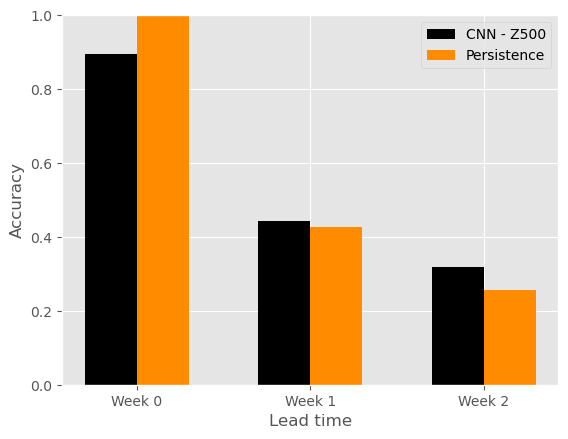

In [41]:
### PLOT BARS ###
plt.bar(np.arange(3),acc_weeks_model,width=-0.3,align='edge',label=f'CNN - {variable.upper()}',color='k')
plt.bar(np.arange(3),acc_weeks_persistence,width=0.3,align='edge',label='Persistence',color='darkorange')
plt.legend()
plt.ylabel('Accuracy')
plt.xticks(np.arange(3),['Week 0','Week 1','Week 2'])
plt.xlabel('Lead time')
plt.ylim(0,1)
plt.savefig(f'{path_figures}Accuracy_DT3.png',bbox_inches='tight')
# plt.close('all')

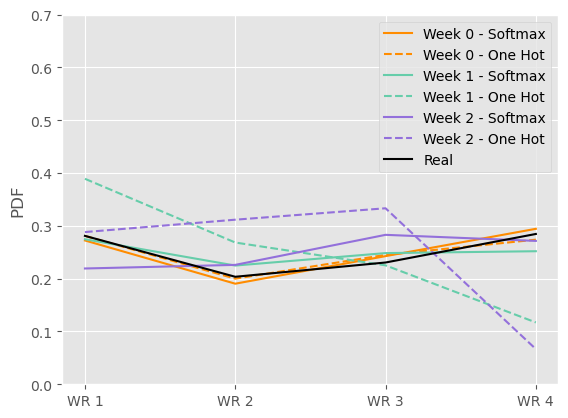

In [42]:
colors= ['darkorange','mediumaquamarine','mediumpurple']

hist_real = np.histogram(df_wr_2['week1'],bins=4)[0]
hist_real_norm = hist_real/np.sum(hist_real)

for i,week in enumerate(['week1','week2','week3']):
    plt.plot(dic_probability['z500'][week].mean(axis=0),
             label=f'{week[:-1].capitalize()} {i} - Softmax',color=colors[i])
    hist_prediction = np.histogram(dic_results4['z500'][week],bins=[-0.5,0.5,1.5,2.5,3.5])[0]
    hist_prediction_norm = hist_prediction/np.sum(hist_prediction)

    plt.plot(np.arange(0,4),hist_prediction_norm,
             label=f'{week[:-1].capitalize()} {i} - One Hot',ls='--',color=colors[i])
    
plt.plot(hist_real_norm,color='k',label='Real')

plt.legend()

plt.ylim(0,0.7)
plt.xticks(np.arange(4),['WR 1','WR 2','WR 3','WR 4'])
plt.ylabel('PDF')
plt.savefig(f'{path_figures}Distributions_DT3.png',bbox_inches='tight')

## Plot accuracy all methods

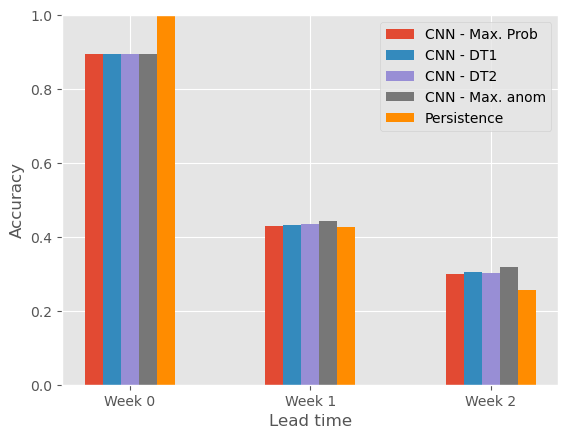

In [43]:
### PLOT BARS ###
N = 3
ind = np.arange(N) 
width = 0.1

plt.bar(ind-width*2,acc_weeks_simple,width=width,label=f'CNN - Max. Prob')
plt.bar(ind-width,acc_weeks_dt1,width=width,label=f'CNN - DT1')
plt.bar(ind,acc_weeks_dt2,width=width,label=f'CNN - DT2')
plt.bar(ind+width,acc_weeks_dt3,width=width,label=f'CNN - Max. anom')
plt.bar(ind+width*2,acc_weeks_persistence,width=width,label='Persistence',color='darkorange')
plt.legend()
plt.ylabel('Accuracy')
plt.xticks(np.arange(3),['Week 0','Week 1','Week 2'])
plt.xlabel('Lead time')
plt.ylim(0,1)
plt.savefig(f'{path_figures}AccuracySummaryTests.png',bbox_inches='tight')
# plt.close('all')

# 5. K-means distance vs. accuracy

In [44]:
distance_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/weekly_distance_mean_geop_v3.csv',
                         index_col = 0,parse_dates=True)

In [45]:
distance_wr = distance_wr.iloc[np.where(df_wr_2.index.year>2010)[0]]

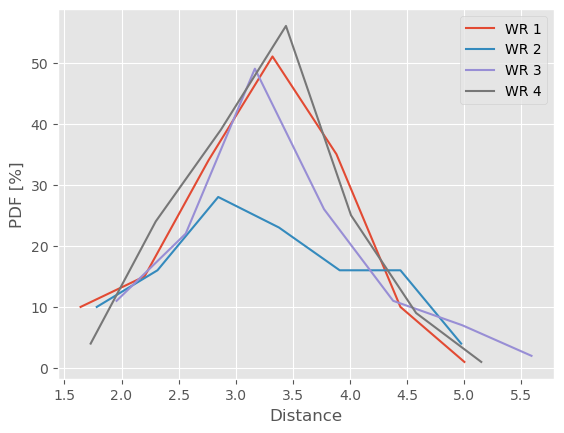

In [46]:
for wr in [0,1,2,3]:
    where_regime = np.where(df_wr_2.week1==wr)[0]
    distances_temp = distance_wr.week1.iloc[where_regime]
    
    hist,bins = np.histogram(distances_temp,bins=7)
    hist_norm = hist/np.sum(hist)
    bins2plot = bins[:-1]+np.diff(bins)[0]/2

    plt.plot(bins2plot,hist,label=f'WR {wr+1}')
plt.xlabel('Distance')
plt.ylabel('PDF [%]')
plt.legend()
plt.savefig(f'{path_figures}WR_Distances_Histograms.png',bbox_inches='tight')

## Accuracy for different distances

In [47]:
res=0.75
bins_distances = np.arange(2,5.5,res)

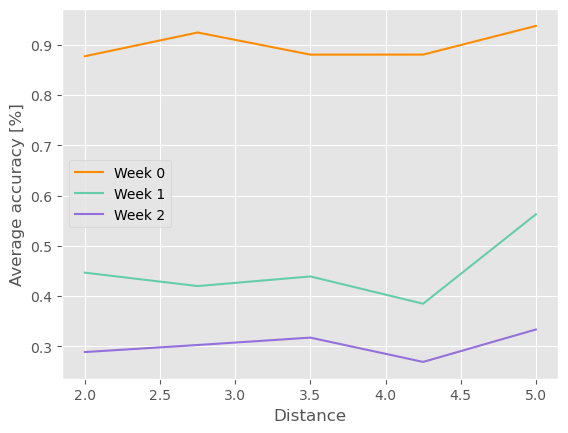

In [48]:
for i,week in enumerate(['week1','week2','week3']):
    accuracies_week = np.zeros([4,len(bins_distances)])
    for j,bin_temp in enumerate(bins_distances):
        distances_temp = distance_wr[week]
        where_distance = np.where((distances_temp>=bin_temp-res/2)&
                                  (distances_temp<bin_temp+res/2))[0]
        # accuracies_week[0,j] = accuracy_score(dic_results['z500'][week].iloc[where_distance],
        #     df_wr_2[week].iloc[where_distance])
        accuracies_week[1,j] = accuracy_score(dic_results2['z500'][week].iloc[where_distance],
            df_wr_2[week].iloc[where_distance])
        # accuracies_week[2,j] = accuracy_score(dic_results3['z500'][week].iloc[where_distance],
        #     df_wr_2[week].iloc[where_distance])
        # accuracies_week[3,j] = accuracy_score(dic_results4['z500'][week].iloc[where_distance],
        #     df_wr_2[week].iloc[where_distance])
        
    # for k in range(1,2):
    #     if k==0:
    plt.plot(bins_distances,accuracies_week[1,:],color=colors[i],label=f'Week {i}')
        # else:
        #     plt.plot(bins_distances,accuracies_week[k,:],color=colors[i])
plt.legend()

plt.xlabel('Distance')
plt.ylabel('Average accuracy [%]')
plt.savefig(f'{path_figures}WRvsDistance.png',bbox_inches='tight')

# 6. More metrics: Contingency tables, HSS, PSS

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

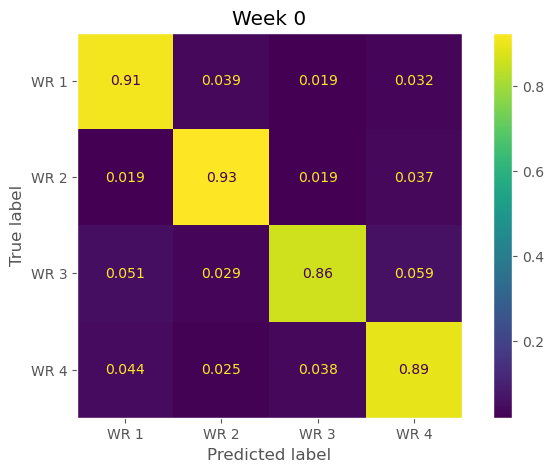

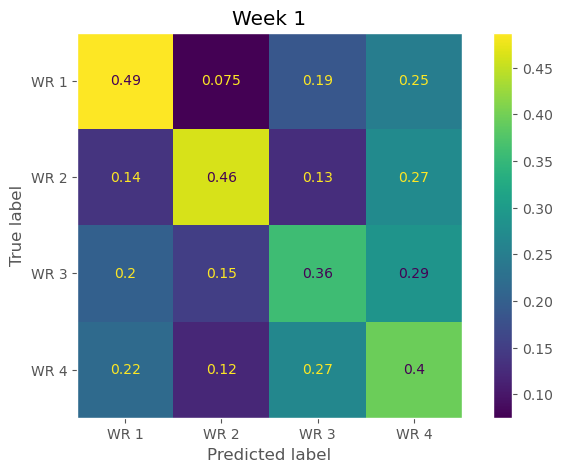

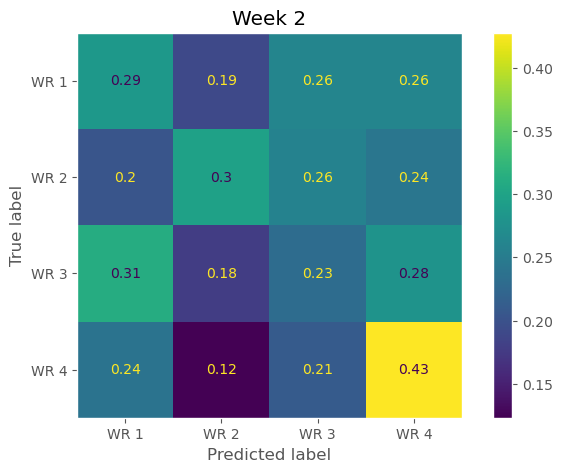

In [50]:
# Plot confusion matrix
for i,week in enumerate(['week1','week2','week3']):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(dic_results['z500'][week], df_wr_2[week],normalize='true'),
        display_labels=["WR 1", "WR 2", "WR 3", "WR 4"],
    )

    cmp.plot(ax=ax)
    ax.grid(False)
    plt.title(f'Week {i}')
    plt.show()

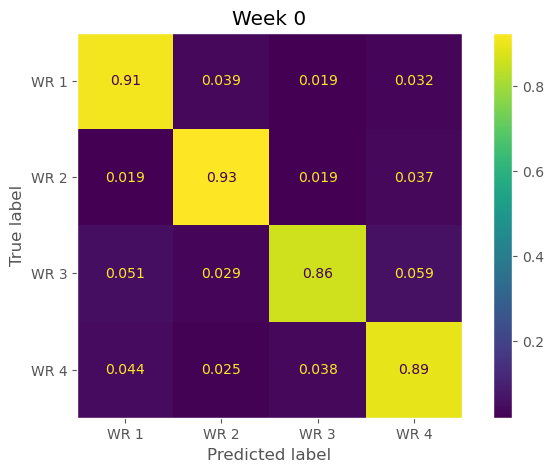

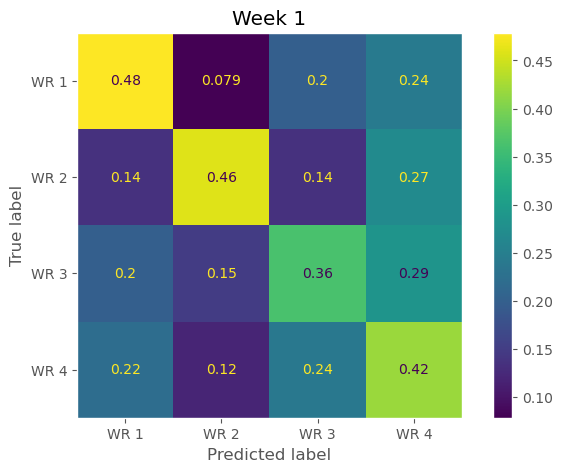

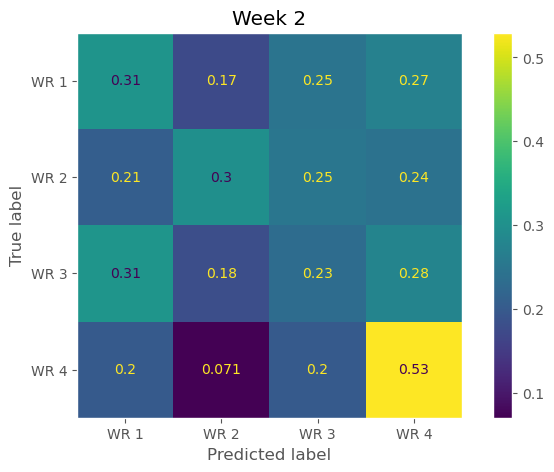

In [51]:
# Plot confusion matrix
for i,week in enumerate(['week1','week2','week3']):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(dic_results2['z500'][week], df_wr_2[week],normalize='true'),
        display_labels=["WR 1", "WR 2", "WR 3", "WR 4"],
    )

    cmp.plot(ax=ax)
    ax.grid(False)
    plt.title(f'Week {i}')
    plt.show()

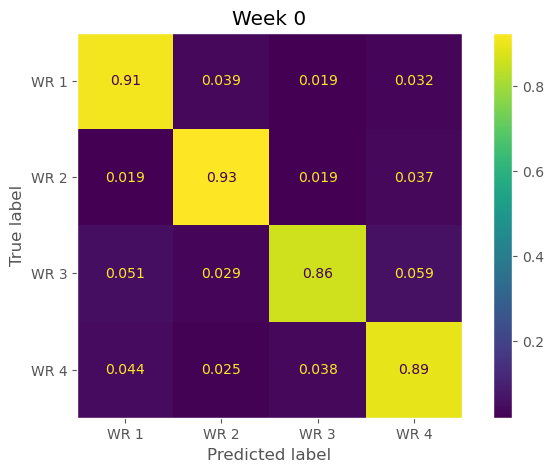

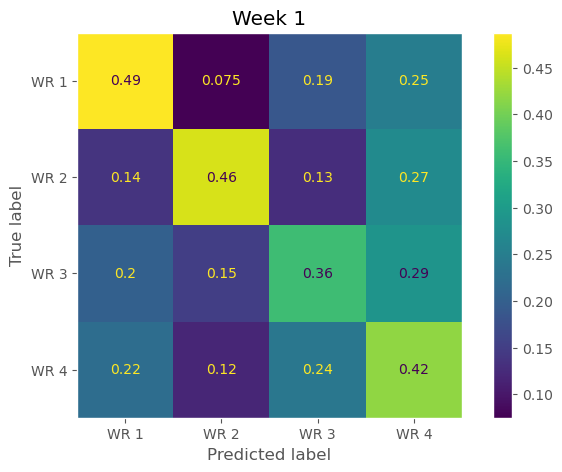

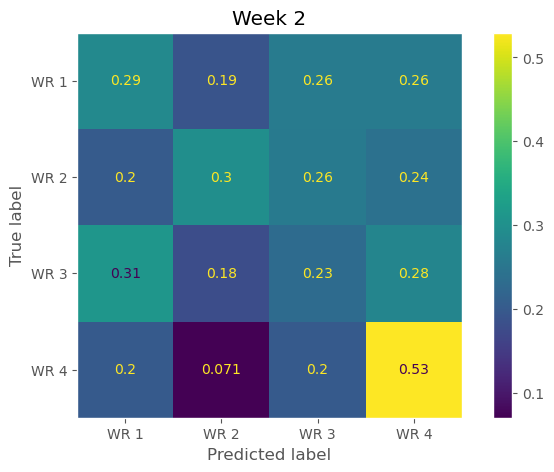

In [52]:
# Plot confusion matrix
for i,week in enumerate(['week1','week2','week3']):
    fig, ax = plt.subplots(figsize=(8, 5))
    where_known = np.where(dic_results3['z500'][week]!=-1)[0]
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(dic_results3['z500'][week][where_known], 
                         df_wr_2[week][where_known],normalize='true'),
        display_labels=["WR 1", "WR 2", "WR 3", "WR 4"],
    )

    cmp.plot(ax=ax)
    ax.grid(False)
    plt.title(f'Week {i}')
    plt.show()

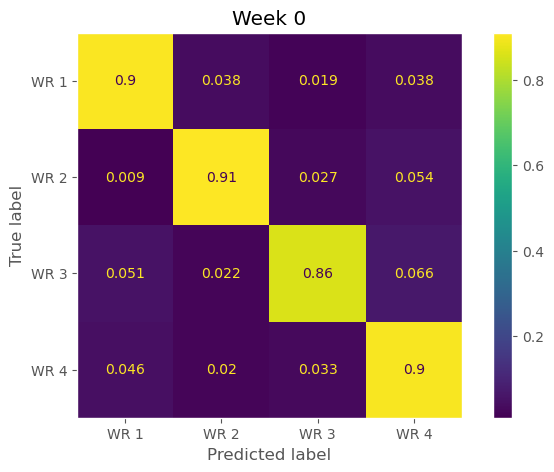

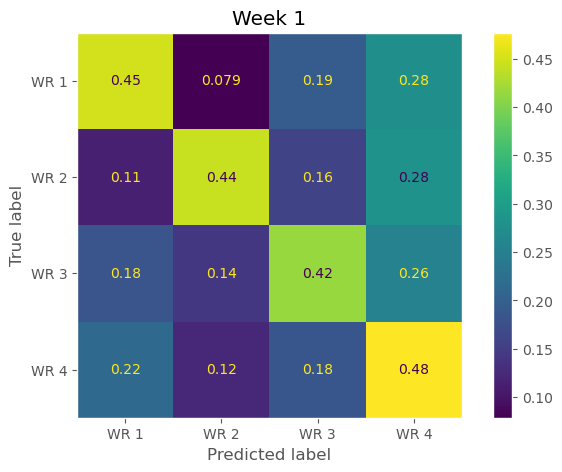

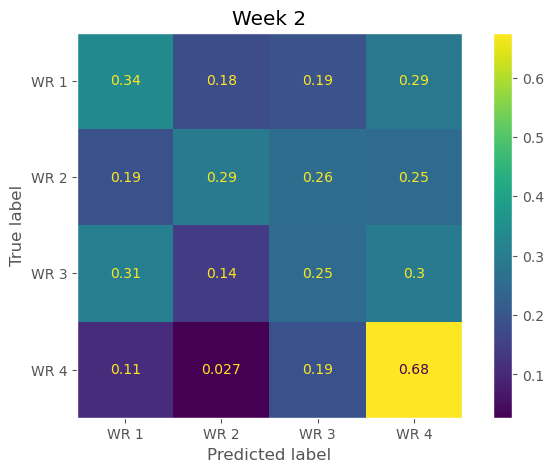

In [53]:
# Plot confusion matrix
for i,week in enumerate(['week1','week2','week3']):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(dic_results4['z500'][week], df_wr_2[week],normalize='true'),
        display_labels=["WR 1", "WR 2", "WR 3", "WR 4"],
    )

    cmp.plot(ax=ax)
    ax.grid(False)
    plt.title(f'Week {i}')
    plt.show()

# HSS, PSS and Brier score

In [54]:
def get_heidke_peirce(predicted,real):
    contingency = verify.ContingencyNxN(confusion_matrix(predicted, real))
    return contingency.heidke(),contingency.peirce()

In [55]:
heidke = np.zeros([5,3])
peirce = np.zeros([5,3])
for i,week in enumerate(['week1','week2','week3']):
    where_known = np.where(dic_results3['z500'][week]!=-1)[0]
    results_listed = [dic_results['z500'][week],
                     dic_results2['z500'][week],
                     dic_results3['z500'][week].iloc[where_known],
                     dic_results4['z500'][week],
                     df_results_persistence[week]]

    for j in range(5):
        if j!=2:
            heidke_temp, peirce_temp = get_heidke_peirce(results_listed[j], df_wr_2[week])
        else:
            heidke_temp, peirce_temp = get_heidke_peirce(results_listed[j], df_wr_2[week].iloc[where_known])
        heidke[j,i] = heidke_temp
        peirce[j,i] = peirce_temp   

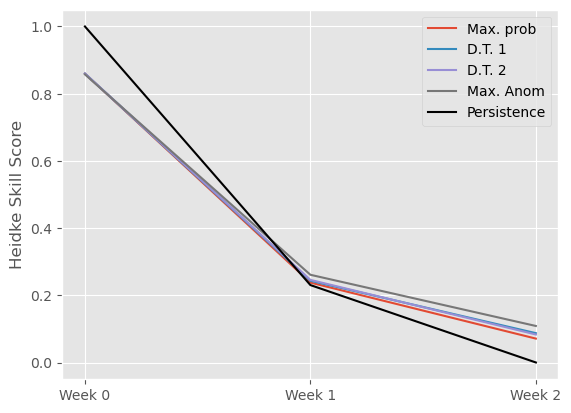

In [56]:
labels = ['Max. prob','D.T. 1','D.T. 2','Max. Anom','Persistence']
for j in range(5):
    
    if j==4:
        plt.plot(heidke[j],label=labels[j],color='k')
    else:
        plt.plot(heidke[j],label=labels[j])
plt.xticks([0,1,2],['Week 0','Week 1','Week 2'])
plt.legend()
plt.ylabel('Heidke Skill Score')
plt.savefig(f'{path_figures}HSS.png',bbox_inches='tight')


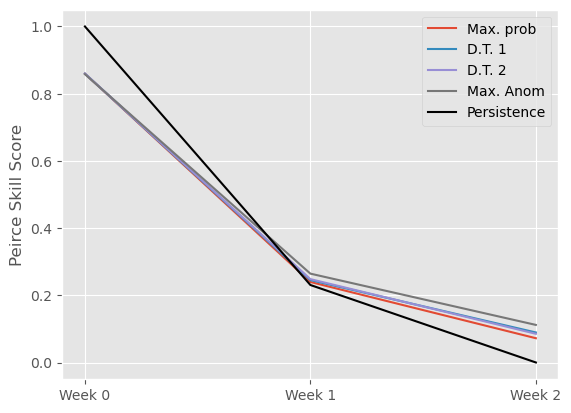

In [57]:
labels = ['Max. prob','D.T. 1','D.T. 2','Max. Anom','Persistence']
for j in range(5):
    
    if j==4:
        plt.plot(peirce[j],label=labels[j],color='k')
    else:
        plt.plot(peirce[j],label=labels[j])
plt.xticks([0,1,2],['Week 0','Week 1','Week 2'])
plt.legend()
plt.ylabel('Peirce Skill Score')
plt.savefig(f'{path_figures}PSS.png',bbox_inches='tight')

# Reliability curves

## Sklearn

In [58]:
from sklearn.calibration import calibration_curve

In [59]:
cc1 = []
cc2 = []
cc4 = []

probs_true_class = []

for i,week in enumerate(['week1','week2','week3']):
    prob_of_true_class = []
    for i in range(len(dic_probability['z500'][week])):
        prob_of_true_class.append(dic_probability['z500'][week][i][df_wr_2[week].iloc[i]])
    probs_true_class.append(prob_of_true_class)
    bins = 7
    strategy = 'uniform'
    
    cc = calibration_curve(np.array(df_wr_2[week].values == dic_results['z500'][week]).astype(int),
                      np.array(prob_of_true_class),n_bins=bins,strategy=strategy)
    cc1.append(cc)
    
    cc = calibration_curve(np.array(df_wr_2[week].values == dic_results2['z500'][week]).astype(int),
                      np.array(prob_of_true_class),n_bins=bins,strategy=strategy)
    cc2.append(cc)
    
    cc = calibration_curve(np.array(df_wr_2[week].values == dic_results4['z500'][week]).astype(int),
                      np.array(prob_of_true_class),n_bins=bins,strategy=strategy)
    cc4.append(cc)

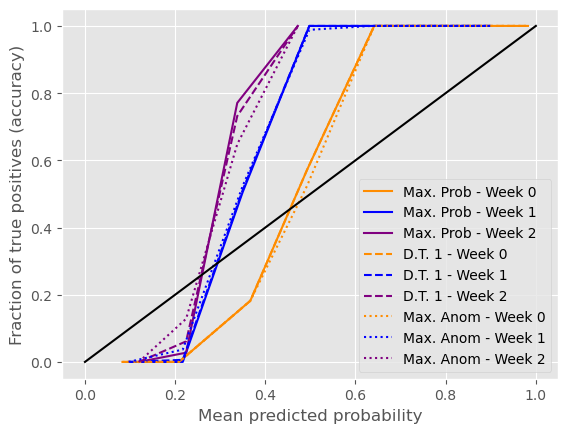

In [60]:
colors = ['darkorange','blue','purple']

for i in range(len(cc1)):
    plt.plot(cc1[i][1],cc1[i][0],label = f'Max. Prob - Week {i}',color=colors[i])
for i in range(len(cc2)):
    plt.plot(cc2[i][1],cc2[i][0],label = f'D.T. 1 - Week {i}',color=colors[i],ls = '--')
for i in range(len(cc4)):
    plt.plot(cc4[i][1],cc4[i][0],label = f'Max. Anom - Week {i}',color=colors[i],ls='dotted')

    
plt.plot([0,1],[0,1],color='k')
plt.legend()
# plt.title('Method: Max. Prob')
plt.ylabel('Fraction of true positives (accuracy)')
plt.xlabel('Mean predicted probability')

plt.savefig(f'{path_figures}ReliabilityCurves.png',bbox_inches='tight')

Text(0.5, 0, 'Mean predicted probability')

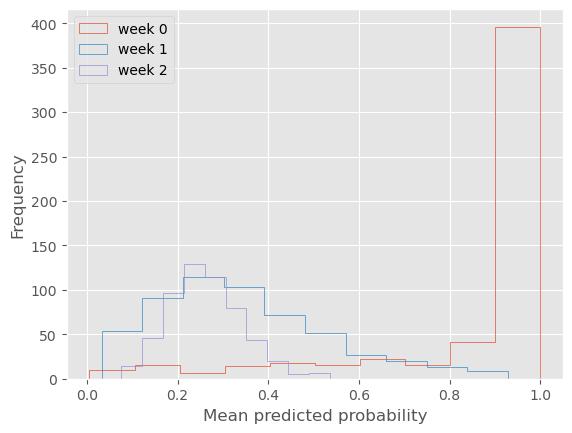

In [61]:
plt.hist(probs_true_class[0],histtype='step',label='week 0')
plt.hist(probs_true_class[1],histtype='step',label='week 1')
plt.hist(probs_true_class[2],histtype='step',label='week 2')

plt.legend(loc='upper left')
plt.ylabel('Frequency')
plt.xlabel('Mean predicted probability')

## Own function

In [62]:
def get_cc(probs_true,real,pred,res_bins = 0.1):
    cc = []
    bins = np.arange(0,1.05,res_bins)
    for ibin in range(len(bins)):
        where_prob = np.where((probs_true>=bins[ibin]-res_bins/2)
                              &(probs_true<=bins[ibin]+res_bins/2))[0]
        real_where_prob = real.values[where_prob]
        pred_where_prob = pred.values[where_prob]
        try:
            acc_temp = len(np.where(real_where_prob == pred_where_prob)[0])\
                /len(real_where_prob)
        except:
            acc_temp = np.nan
        cc.append(acc_temp)
    return bins, cc

In [63]:
cc1 = []
cc2 = []
cc4 = []

probs_true_class = []

for i,week in enumerate(['week1','week2','week3']):
    prob_of_true_class = []
    for i in range(len(dic_probability['z500'][week])):
        prob_of_true_class.append(dic_probability['z500'][week][i][df_wr_2[week].iloc[i]])
    probs_true_class.append(prob_of_true_class)

    cc = get_cc(prob_of_true_class,df_wr_2[week],dic_results['z500'][week])
    cc1.append(cc)
    
    cc = get_cc(prob_of_true_class,df_wr_2[week],dic_results2['z500'][week])
    cc2.append(cc)
    
    cc = get_cc(prob_of_true_class,df_wr_2[week],dic_results4['z500'][week])
    cc4.append(cc)

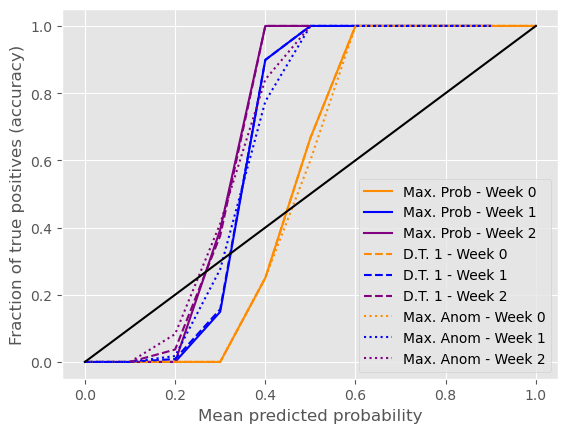

In [64]:
colors = ['darkorange','blue','purple']

for i in range(len(cc1)):
    where_finite = np.where(np.isfinite(cc1[i][1]))[0]
    plt.plot(np.array(cc1[i][0])[where_finite],
             np.array(cc1[i][1])[where_finite],label = f'Max. Prob - Week {i}',color=colors[i])
for i in range(len(cc2)):
    where_finite = np.where(np.isfinite(cc2[i][1]))[0]
    plt.plot(np.array(cc2[i][0])[where_finite],
             np.array(cc2[i][1])[where_finite],label = f'D.T. 1 - Week {i}',color=colors[i],ls = '--')
for i in range(len(cc4)):
    where_finite = np.where(np.isfinite(cc4[i][1]))[0]
    plt.plot(np.array(cc4[i][0])[where_finite],
             np.array(cc4[i][1])[where_finite],label = f'Max. Anom - Week {i}',color=colors[i],ls='dotted')

    
plt.plot([0,1],[0,1],color='k')
plt.legend()
# plt.title('Method: Max. Prob')
plt.ylabel('Fraction of true positives (accuracy)')
plt.xlabel('Mean predicted probability')

plt.savefig(f'{path_figures}ReliabilityCurves_v2.png',bbox_inches='tight')

# Brier score

In [65]:
def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))/4

In [66]:
b_score = []
b_score_pers = []
for i,week in enumerate(['week1','week2','week3']):
    serie_wr_categorical = to_categorical(df_wr_2[week],num_classes=4)
    serie_wr_categorical_p = to_categorical(df_wr_2['week1'],num_classes=4)
    b_score.append(brier_multi(serie_wr_categorical,dic_probability['z500'][week]))
    b_score_pers.append(brier_multi(serie_wr_categorical,serie_wr_categorical_p))
    

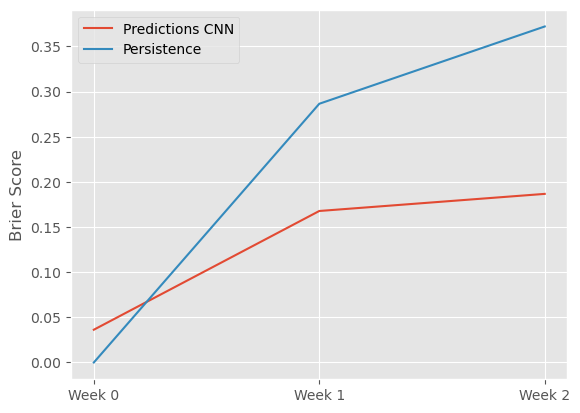

In [ ]:
plt.plot(b_score,label='Predictions CNN')
plt.plot(b_score_pers,label='Persistence')
plt.xticks([0,1,2],['Week 0','Week 1','Week 2'])
plt.legend()
plt.ylabel('Brier Score')
plt.savefig(f'{path_figures}BSS.png',bbox_inches='tight')

In [69]:
np.array(b_score) - np.array(b_score_pers)

array([ 0.03627633, -0.11873139, -0.18537304])